# Stock Price Prediction Using Machine Learning
---

## Fetch Historical Stock Data

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anish\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price        Date      Open      High       Low     Close     Volume
Ticker                 NVDA      NVDA      NVDA      NVDA       NVDA
0      2000-01-03  0.090268  0.090984  0.084297  0.089431  300912000
1      2000-01-04  0.087879  0.088118  0.082625  0.087044  300480000
2      2000-01-05  0.084536  0.085969  0.082984  0.084178  188352000
3      2000-01-06  0.084178  0.084178  0.075462  0.078685  120480000
4      2000-01-07  0.078327  0.080835  0.077134  0.079999   71184000


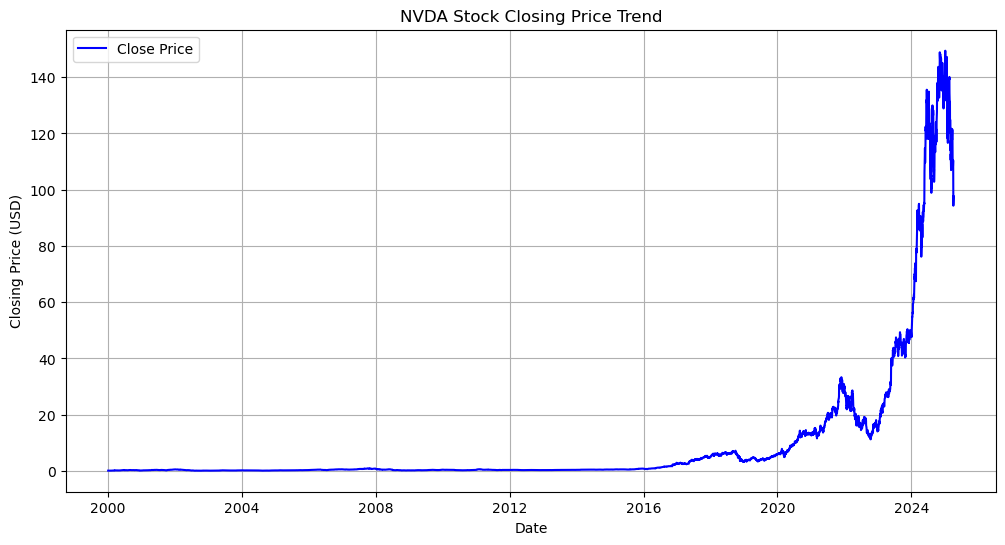

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import requests
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


 # Download the VADER lexicon (if not already downloaded)
nltk.download('vader_lexicon')

# Define parameters for data fetching
ticker = "NVDA"
start_date = "2000-01-01"
end_date = "2025-04-08"

# Fetch historical stock data
stock_data = yf.download(ticker, start=start_date, end=end_date)
if stock_data.empty:
    raise ValueError("No data found for ticker.")
stock_data.reset_index(inplace=True)

# Select necessary columns
df = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
print(df.head())

# Scale the 'Close' prices (for use in ML models later)
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

# Plot 'Close' prices 
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker} Stock Closing Price Trend')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid()
plt.show()

## Use current news sentiment for better prediction
def get_current_news_sentiment(ticker, api_key):
    """
    Fetches recent news articles for the given ticker using NewsAPI,
    analyzes the sentiment of the headlines using VADER, and returns the average sentiment.
    The sentiment score ranges from -1 (very negative) to 1 (very positive).
    """
    url = f'https://newsapi.org/v2/everything?q={ticker}&sortBy=publishedAt&language=en&apiKey={api_key}'
    response = requests.get(url)
    data = response.json()
    articles = data.get('articles', [])
    if not articles:
        return 0.0  # Neutral sentiment if no articles found
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = []
    for article in articles:
        headline = article.get('title', '')
        if headline:
            score = sid.polarity_scores(headline)['compound']
            sentiment_scores.append(score)
    if sentiment_scores:
        average_sentiment = np.mean(sentiment_scores)
        return average_sentiment
    else:
        return 0.0


# # OPTIONAL: Demonstrate inverse transformation of scaled data
# # This can be useful if your model predictions come in the scaled range.
# scaled_values = df['Close_Scaled'].values.reshape(-1, 1)
# original_values = scaler.inverse_transform(scaled_values)

# plt.figure(figsize=(12, 6))
# plt.plot(df['Date'], original_values, label='Inverse Transformed Scaled Data', color='green')
# plt.title(f'{ticker} Stock Closing Price Trend (Inverse Transformed)')
# plt.xlabel('Date')
# plt.ylabel('Closing Price (USD)')
# plt.legend()
# plt.grid()
# plt.show()
 

 ## Prepare stock price data for LSTM model

X_train_lstm shape: (5035, 60)
y_train_lstm shape: (5035,)
X_test_lstm shape: (1259, 60)
y_test_lstm shape: (1259,)


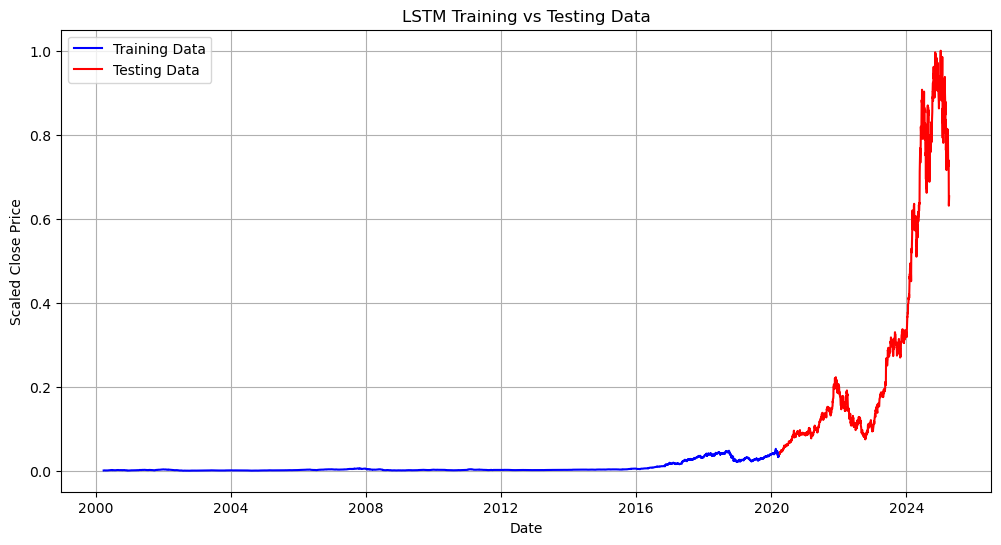

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Scale the 'Close' prices for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])  

# Function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 60
X_lstm, y_lstm = create_sequences(df['Close_Scaled'].values, sequence_length)

# Split data into training and testing sets (80% training, 20% testing)
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Print shapes for verification
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

# # Visualization: Scaled Close prices
# plt.figure(figsize=(12, 6))
# plt.plot(df['Date'], df['Close_Scaled'], label='Scaled Close Price', color='green')
# plt.title('Scaled Close Prices for LSTM')
# plt.xlabel('Date')
# plt.ylabel('Scaled Value')
# plt.legend()
# plt.grid()
# plt.show()

# Visualization: Training vs Testing split
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][sequence_length:split_idx + sequence_length], y_train_lstm, label='Training Data', color='blue')
plt.plot(df['Date'][split_idx + sequence_length:], y_test_lstm, label='Testing Data', color='red')
plt.title('LSTM Training vs Testing Data')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid()
plt.show()

## Training LSTM model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
158/158 [==============================] 

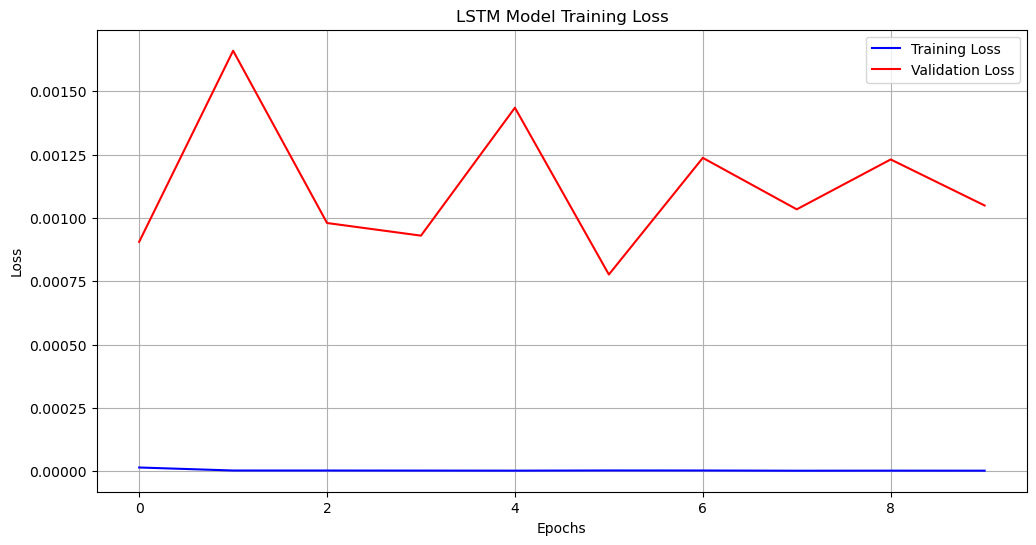

197/197 [==============================] - 5s 20ms/step


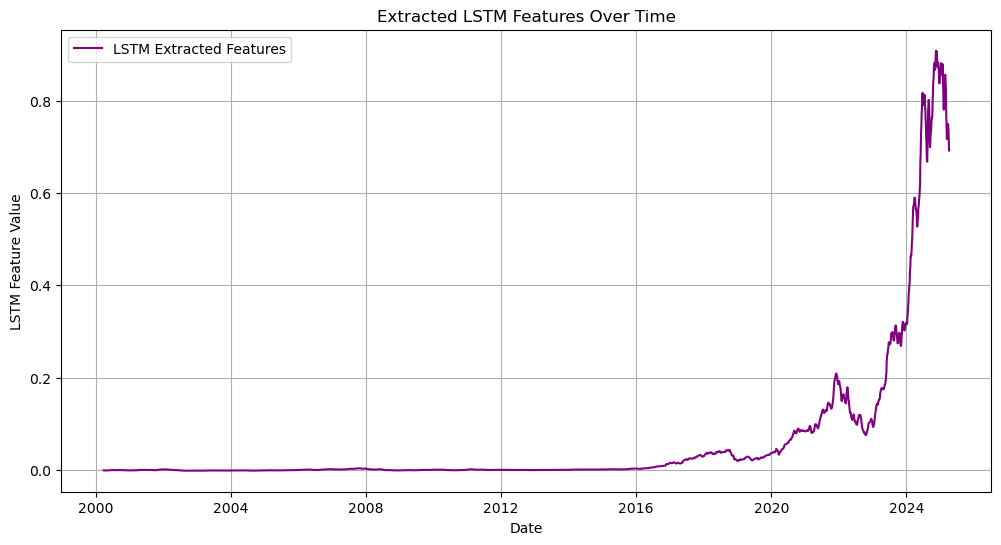

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Ensure reproducibility
np.random.seed(42)

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1), activation='tanh'),
    Dropout(0.2),  # Add dropout for regularization
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Output layer
])

# Compile the LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print model summary
lstm_model.summary()

# Train LSTM with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_lstm, 
    epochs=10,  # number of learning
    batch_size=32, 
    validation_data=(X_test_lstm, y_test_lstm), # monitor performance on unseen data
    verbose=1,
    callbacks=[early_stopping]
)

# Plotting Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# # Plotting Mean Absolute Error
# plt.figure(figsize=(12, 6))
# plt.plot(history.history['mae'], label='Training MAE', color='blue')
# plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
# plt.title('LSTM Model Mean Absolute Error')
# plt.xlabel('Epochs')
# plt.ylabel('MAE')
# plt.legend()
# plt.grid()
# plt.show()

# Extract LSTM features
lstm_features = lstm_model.predict(X_lstm)

# Ensure a copy of the DataFrame is explicitly used
df = df.copy()

# Initialize the LSTM features column in the DataFrame
df['LSTM_Features'] = np.nan  # Avoid SettingWithCopyWarning


if len(lstm_features.flatten()) == len(df) - sequence_length - 1:
    df.loc[sequence_length + 1:, 'LSTM_Features'] = lstm_features.flatten()
elif len(lstm_features.flatten()) == len(df) - sequence_length:
    df.loc[sequence_length:, 'LSTM_Features'] = lstm_features.flatten()
else:
    raise ValueError(
        f"Mismatch in lengths: LSTM features ({len(lstm_features.flatten())}) "
        f"and DataFrame rows after sequence_length ({len(df) - sequence_length})."
    )

# Plot the extracted LSTM features
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][sequence_length:], df['LSTM_Features'][sequence_length:], label='LSTM Extracted Features', color='purple')
plt.title('Extracted LSTM Features Over Time')
plt.xlabel('Date')
plt.ylabel('LSTM Feature Value')
plt.legend()
plt.grid()
plt.show()


## Analyze stock prices by technical indicators such as SMA, EMA, RSI

C:\Users\anish\AppData\Local\Temp\ipykernel_33468\329881135.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


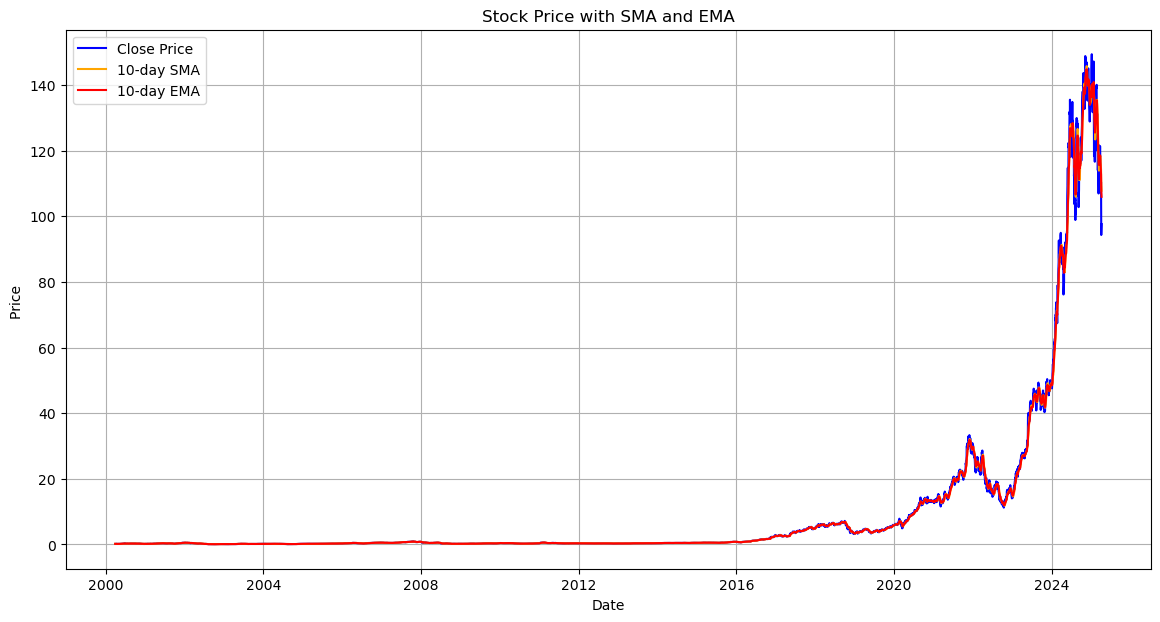

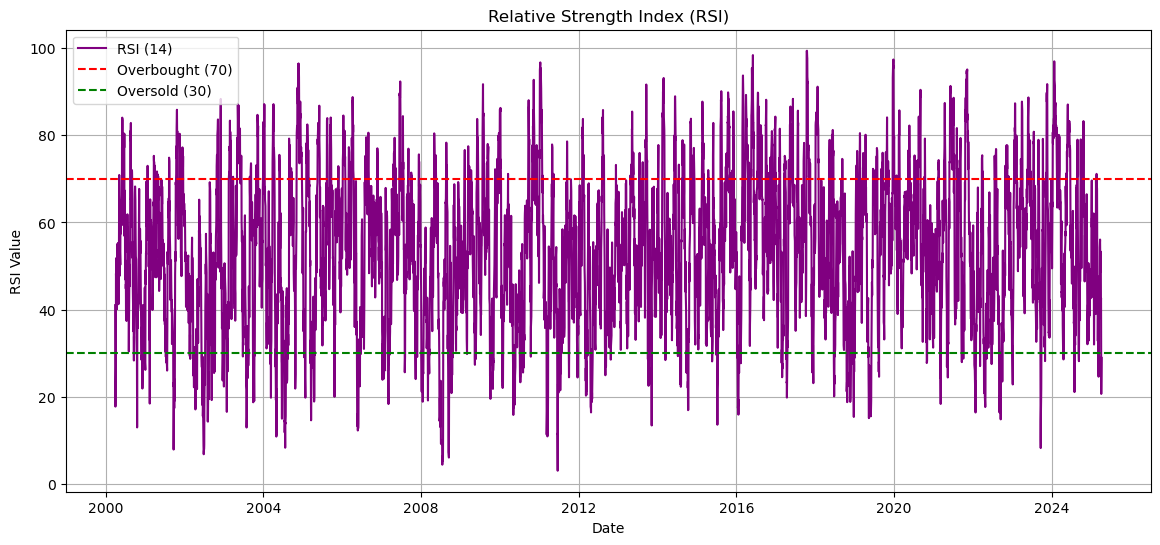

In [4]:
import matplotlib.pyplot as plt

# Add Simple Moving Average (SMA) and Exponential Moving Average (EMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_10'] = df['Close'].ewm(span=10).mean()

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss #Ratio of average gain to average loss
    return 100 - (100 / (1 + rs))

# Add RSI to the DataFrame
df['RSI'] = calculate_rsi(df['Close'])

# Incorporate news sentiment as an additional feature.
# For historical data, we'll assume neutral sentiment (0.0); this feature will be updated with real sentiment for the final prediction.
df['News_Sentiment'] = 0.0


# Removes these missing rows from the dataset
# Drop NaN rows (due to rolling calculations)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Visualization: Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['SMA_10'], label='10-day SMA', color='orange')
plt.plot(df['Date'], df['EMA_10'], label='10-day EMA', color='red')
plt.title('Stock Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price ')
plt.legend()
plt.grid()
plt.show()

# Visualization: RSI Indicator
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['RSI'], label='RSI (14)', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)') # Selling Opportunity
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)') # Buying Opportunity
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid()
plt.show()


## Prepare data for training Gradient Boosting model

In [5]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare features and target for Gradient Boosting model
features = ['LSTM_Features', 'SMA_10', 'EMA_10', 'RSI', 'Volume','News_Sentiment']

# Ensure no missing values in selected features
X_xgb = df[features].dropna()
y_xgb = df.loc[X_xgb.index, 'Close']

# Check for data availability before splitting
if X_xgb.shape[0] == 0:
  print("Error: No data available for train-test split. Please check your dataframe.")
else:
  # test size 
  test_size = min(0.2, 1 - 1/X_xgb.shape[0])  # Ensure test size is less than 1 - 1/n_samples

  # Train-test split 
  X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
      X_xgb, y_xgb, test_size=test_size, random_state=42
  )

  # Print dataset shapes for verification
  print(f"X_train_xgb shape: {X_train_xgb.shape}")
  print(f"X_test_xgb shape: {X_test_xgb.shape}")
  print(f"y_train_xgb shape: {y_train_xgb.shape}")
  print(f"y_test_xgb shape: {y_test_xgb.shape}")

  # # Visualizing feature correlations using a heatmap
  # plt.figure(figsize=(10, 6))
  # correlation_matrix = X_xgb.corr()
  # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  # plt.title('Feature Correlation Heatmap')
  # plt.show()

X_train_xgb shape: (5035, 6)
X_test_xgb shape: (1259, 6)
y_train_xgb shape: (5035, 1)
y_test_xgb shape: (1259, 1)


## Training Gradient boosting model

XGBoost RMSE: 1.06
XGBoost R² Score: 1.00


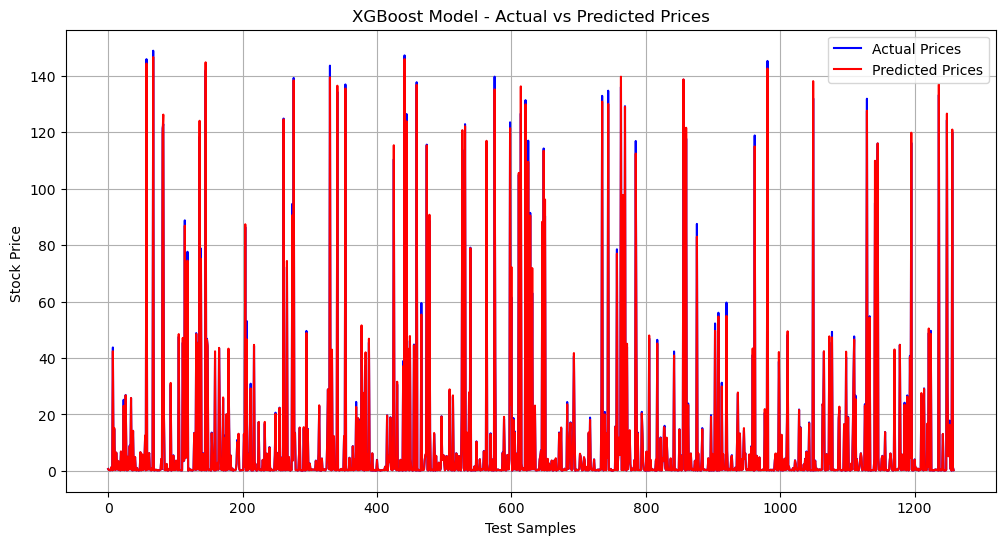

<Figure size 1000x600 with 0 Axes>

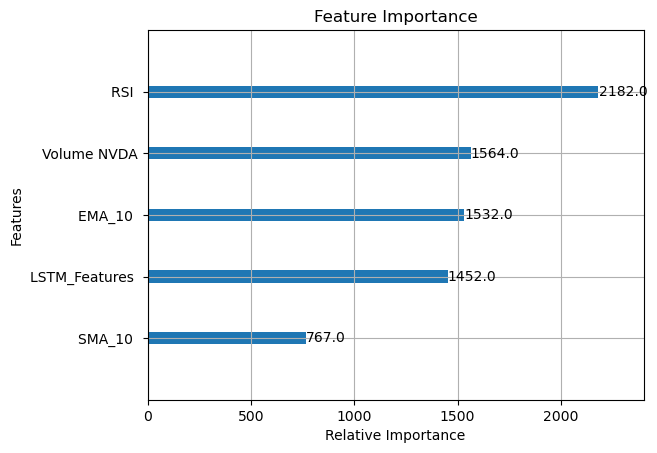

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Train the XGBoost model with optimal parameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,       #  Number of boosting rounds - Increased for better learning
    learning_rate=0.05,     # Step size shrinkage to prevent overfitting - Reduced to improve generalization
    max_depth=6,            # Depth of trees
    subsample=0.8,            # 80% of data for training To reduce overfitting
    colsample_bytree=0.8,   # Randomly selects 80% of features for training (adds diversity)
    random_state=42          # Ensures reproducibility
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test_xgb)
rmse = mean_squared_error(y_test_xgb, y_pred_xgb, )
r2 = r2_score(y_test_xgb, y_pred_xgb)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R² Score: {r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_xgb.values, label='Actual Prices', color='blue')
plt.plot(y_pred_xgb, label='Predicted Prices', color='red')
plt.title('XGBoost Model - Actual vs Predicted Prices')
plt.xlabel('Test Samples')
plt.ylabel('Stock Price ')
plt.legend()
plt.grid()
plt.show()

# Feature importance visualization
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance', xlabel='Relative Importance')
plt.show()

## Store LSTM & XGBoost Model in appropriate formats

In [7]:
import joblib
from tensorflow.keras.models import load_model

# Save the LSTM model in HDF5 format
lstm_model.save('lstm_model.h5')
print("LSTM model saved successfully as 'lstm_model.h5'.")

# Save the XGBoost model using joblib
joblib.dump(xgb_model, 'xgb_model.pkl')
print("XGBoost model saved successfully as 'xgb_model.pkl'.")

# Validation: Load and test models
try:
    # Load LSTM model to check if it was saved correctly
    loaded_lstm_model = load_model('lstm_model.h5')
    print("LSTM model loaded successfully.")

    # Load XGBoost model to verify serialization
    loaded_xgb_model = joblib.load('xgb_model.pkl')
    print("XGBoost model loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")

LSTM model saved successfully as 'lstm_model.h5'.
XGBoost model saved successfully as 'xgb_model.pkl'.
LSTM model loaded successfully.
XGBoost model loaded successfully.


## Combines LSTM model and XGBoost model for final price prediction

Current news sentiment for NVDA: 0.16
1/1 [==============================] - 1s 943ms/step
LSTM Model predicted price: 101.16
XGBoost Model predicted price: 88.69
Final Predicted Closing Price: 88.69


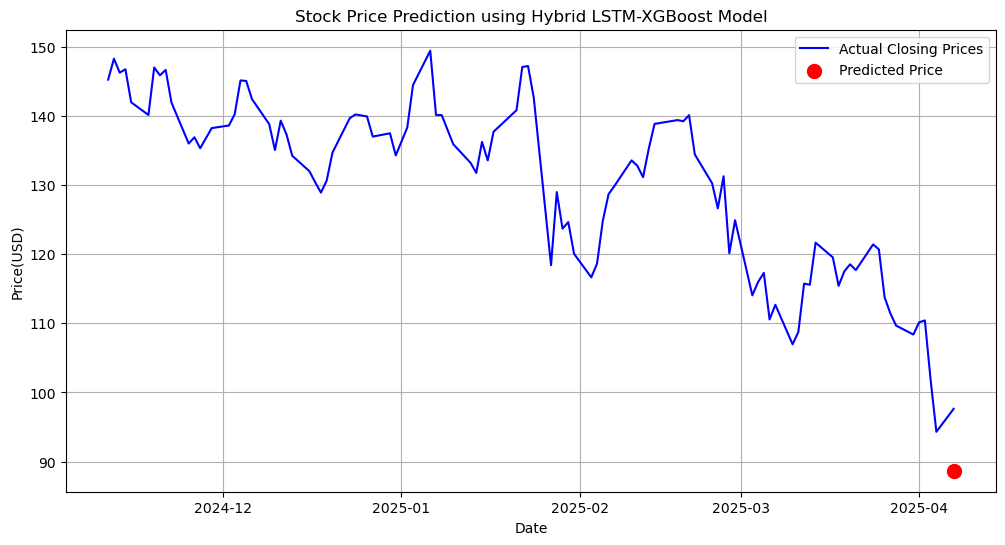

In [8]:
import numpy as np

# call get_current_news_sentiment
api_key = '129673ccd5c1442bbbaed223fab76f93' 
current_news_sentiment = get_current_news_sentiment(ticker, api_key)
print(f"Current news sentiment for {ticker}: {current_news_sentiment:.2f}")

# Update the latest row's news sentiment with the current sentiment value
df.loc[df.index[-1], 'News_Sentiment'] = current_news_sentiment

# Prepare the last sequence of scaled close prices for LSTM prediction
new_data = df[['Close_Scaled']].values[-sequence_length:]
new_data = new_data.reshape(1, sequence_length, 1)  # Reshape for LSTM input

# Predict LSTM features for the new data
new_lstm_features = lstm_model.predict(new_data)

# Calculate LSTM predicted price (convert from scaled to original)
lstm_pred_scaled = new_lstm_features[-1, 0]
lstm_pred = scaler.inverse_transform(np.array([[lstm_pred_scaled]]))[0, 0]


# Prepare XGBoost input using the latest technical features
new_xgb_input = df[['SMA_10', 'EMA_10', 'RSI', 'Volume','News_Sentiment']].iloc[-1].copy()   # Copy to avoid SettingWithCopyWarning
new_xgb_input['LSTM_Features'] = new_lstm_features[-1, 0]  # Add LSTM extracted feature
final_prediction = xgb_model.predict(new_xgb_input.values.reshape(1, -1))
xgb_pred = final_prediction[0]

# Print predictions from both models and the final prediction
print(f"LSTM Model predicted price: {lstm_pred:.2f}")
print(f"XGBoost Model predicted price: {xgb_pred:.2f}")
print(f"Final Predicted Closing Price: {xgb_pred:.2f}")                                                                                             

# Visualization: Compare actual vs predicted value
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-100:], df['Close'].iloc[-100:], label='Actual Closing Prices', color='blue')
plt.scatter(df['Date'].iloc[-1], xgb_pred, color='red', label='Predicted Price', marker='o', s=100)
plt.title('Stock Price Prediction using Hybrid LSTM-XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid()
plt.show()
